# Chapter 7: Matched-Pairs Experiment

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf

# viz
import matplotlib
import matplotlib.pyplot as plt

font = {"family": "IBM Plex Sans Condensed", "weight": "normal", "size": 10}
plt.rc("font", **font)
plt.rcParams["figure.figsize"] = (6, 6)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

%load_ext watermark
%watermark --iversions

pandas           : 2.1.1
matplotlib       : 3.8.0
statsmodels      : 0.13.5
numpy            : 1.23.5
scipy            : 1.11.3
matplotlib_inline: 0.1.6



In [2]:
def MP_enumerate(i, n_pairs):
    if i > 2**n_pairs:
        return None
    a = 2 ** np.arange(n_pairs)[::-1]
    b = 2 * a
    return 2 * (i % b >= a) - 1

In [3]:
# ZeaMays from HistData r package
ZeaMays = pd.read_csv("ZeaMays.csv")
ZeaMays.head()

,pair,pot,cross,self,diff
0,1,1,23.500,17.375,6.125
1,2,1,12.000,20.375,-8.375
2,3,1,21.000,20.000,1.000
3,4,2,22.000,20.000,2.000
4,5,2,19.125,18.375,0.750


Randomization distribution

In [4]:
t_obs = ZeaMays["diff"].mean()
abs_diff = np.abs(ZeaMays["diff"].values)
n_pairs = ZeaMays.shape[0]
t_ran = (
    np.array([np.sum(MP_enumerate(i, 15) * abs_diff) for i in range(1, 2**15)])
    / n_pairs
)
(p_value := np.mean(t_ran >= t_obs))

0.026337473677785578

Text(0.05, 0.9, 'p-value = 0.026')

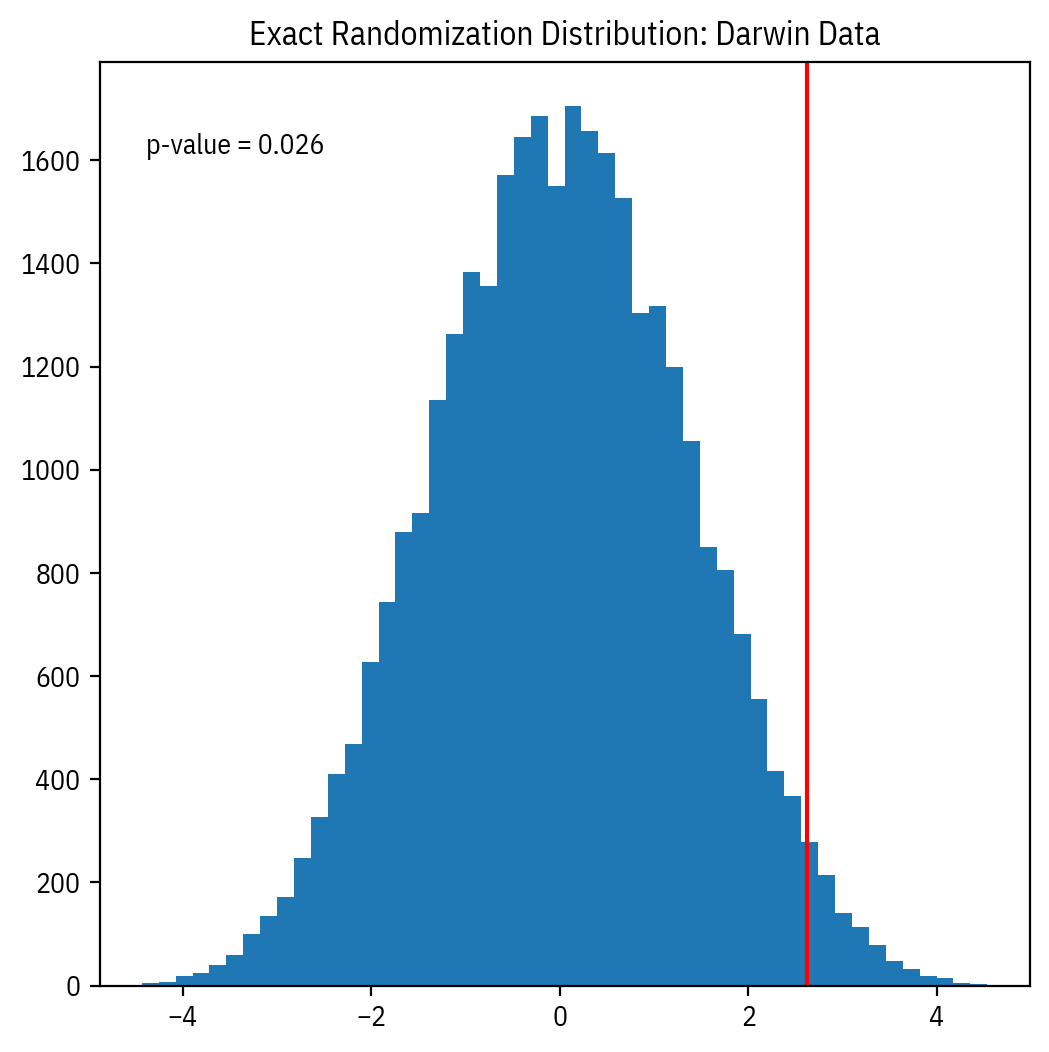

In [5]:
plt.hist(t_ran, bins=50)
plt.axvline(t_obs, color="red")
plt.title("Exact Randomization Distribution: Darwin Data")
plt.annotate(f"p-value = {p_value:.3f}", xy=(0.05, 0.9), xycoords="axes fraction")

IR(2015) : Children's TV Data

In [6]:
dataxy = np.array(
    [
        12.9,
        12.0,
        54.6,
        60.6,
        15.1,
        12.3,
        56.5,
        55.5,
        16.8,
        17.2,
        75.2,
        84.8,
        15.8,
        18.9,
        75.6,
        101.9,
        13.9,
        15.3,
        55.3,
        70.6,
        14.5,
        16.6,
        59.3,
        78.4,
        17.0,
        16.0,
        87.0,
        84.2,
        15.8,
        20.1,
        73.7,
        108.6,
    ]
)
dataxy = dataxy.reshape(-1, 4)
diffx = dataxy[:, 1] - dataxy[:, 0]
diffy = dataxy[:, 3] - dataxy[:, 2]
dataxy = np.c_[dataxy, diffx, diffy]
dataxy = pd.DataFrame(
    dataxy,
    columns=["x_control", "x_treatment", "y_control", "y_treatment", "diffx", "diffy"],
    index=np.arange(1, 9),
)
dataxy

,x_control,x_treatment,y_control,y_treatment,diffx,diffy
1,12.9,12.0,54.6,60.6,-0.9,6.0
2,15.1,12.3,56.5,55.5,-2.8,-1.0
3,16.8,17.2,75.2,84.8,0.4,9.6
4,15.8,18.9,75.6,101.9,3.1,26.3
5,13.9,15.3,55.3,70.6,1.4,15.3
6,14.5,16.6,59.3,78.4,2.1,19.1
7,17.0,16.0,87.0,84.2,-1.0,-2.8
8,15.8,20.1,73.7,108.6,4.3,34.9


In [7]:
tauhat = (dataxy.diffy.mean(),)
sehat = np.sqrt(dataxy.diffy.var(ddof=1) / dataxy.shape[0])
tauhat, sehat

((13.425,), 4.6363374553628)

With a regression

In [8]:
unadj_res = sm.OLS(dataxy.diffy, np.repeat(1, dataxy.shape[0])).fit().summary()
unadj_t = float(unadj_res.tables[1].data[1][3])
unadj_res.tables[1]

/home/alal/anaconda3/envs/econometrics/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


,coef,std err,t,P>|t|,[0.025,0.975]
const,13.4250,4.636,2.896,0.023,2.462,24.388


In [9]:
adj_res = sm.OLS(dataxy.diffy, sm.add_constant(dataxy.diffx)).fit().summary()
adj_t = float(adj_res.tables[1].data[1][3])
adj_res.tables[1]

/home/alal/anaconda3/envs/econometrics/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


,coef,std err,t,P>|t|,[0.025,0.975]
const,8.9943,1.410,6.381,0.001,5.545,12.443
diffx,5.3705,0.599,8.964,0.000,3.904,6.837


In [ ]:
import warnings

warnings.simplefilter("once", category=UserWarning)


def randist(x):
    z_mpe = MP_enumerate(x, 8)
    diffy_mpe = dataxy.diffy * z_mpe
    diffx_mpe = dataxy.diffx * z_mpe
    m0 = sm.OLS(diffy_mpe, np.repeat(1, dataxy.shape[0])).fit().summary()
    m1 = sm.OLS(diffy_mpe, sm.add_constant(diffx_mpe)).fit().summary()
    return float(m0.tables[1].data[1][3]), float(m1.tables[1].data[1][3])


t_randist = np.r_[[randist(i) for i in range(1, 2**8 + 1)]]

In [11]:
p_unadjusted = np.mean(np.abs(t_randist[:, 0]) >= np.abs(unadj_t))
p_adjusted = np.mean(np.abs(t_randist[:, 1]) >= np.abs(adj_t))
p_unadjusted, p_adjusted

(0.03125, 0.0078125)

Text(0.05, 0.9, 'p-value = 0.008')

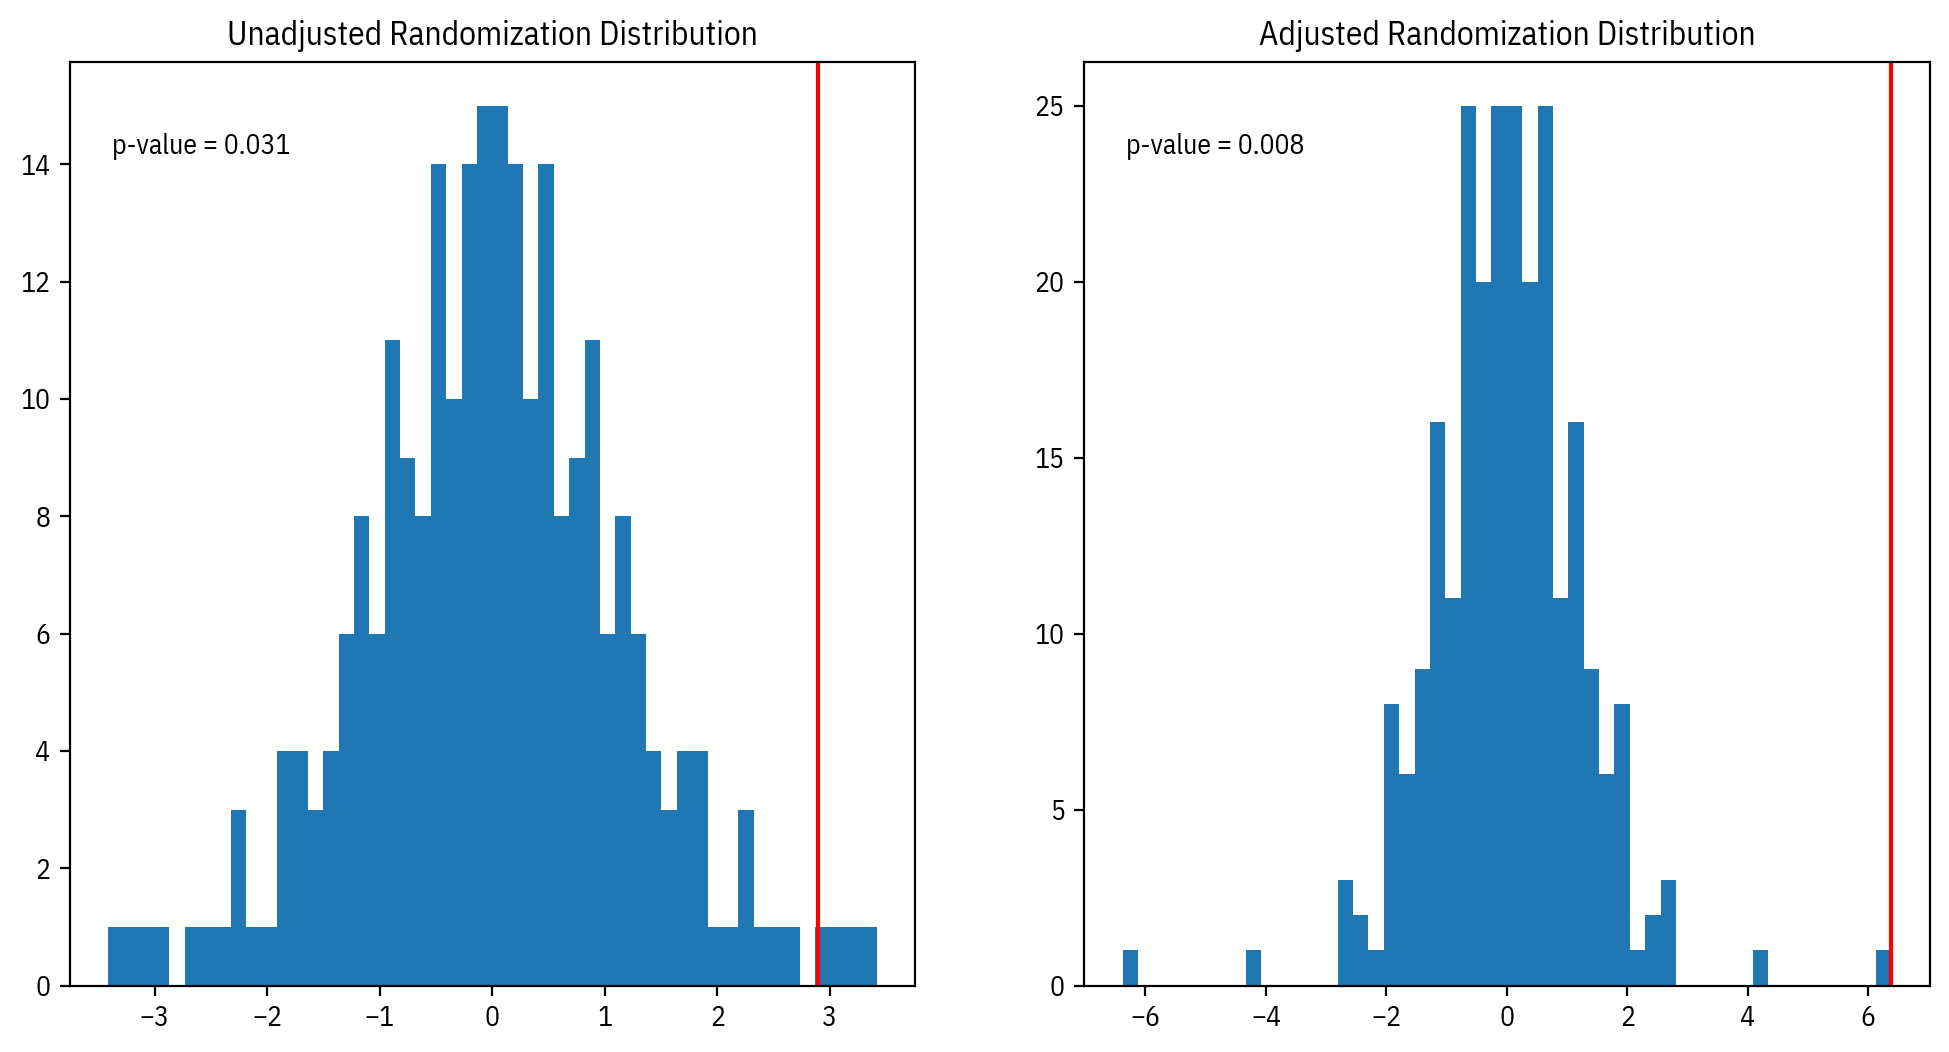

In [12]:
f, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(t_randist[:, 0], bins=50)
ax[0].axvline(unadj_t, color="red")
ax[0].set_title("Unadjusted Randomization Distribution")
ax[0].annotate(
    f"p-value = {p_unadjusted:.3f}", xy=(0.05, 0.9), xycoords="axes fraction"
)
ax[1].hist(t_randist[:, 1], bins=50)
ax[1].axvline(adj_t, color="red")
ax[1].set_title("Adjusted Randomization Distribution")
ax[1].annotate(f"p-value = {p_adjusted:.3f}", xy=(0.05, 0.9), xycoords="axes fraction")